# Camera Position Estimation

## Rendering a test image

* [Dissecting the Camera Matrix, Part 3: The Intrinsic Matrix](http://ksimek.github.io/2013/08/13/intrinsic/)
* [Understanding the View Matrix](https://www.3dgep.com/understanding-the-view-matrix/)

In [1]:
from typing import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Vec2 = NamedTuple('Vec2', [('x', float), ('y', float)])
Vec3 = NamedTuple('Vec3', [('x', float), ('y', float), ('z', float)])
Vec4 = NamedTuple('Vec4', [('x', float), ('y', float), ('z', float), ('w', float)])

Here are some standard transformation matrices (in case we need them):

In [3]:
def translation(t: Vec3) -> np.ndarray:
    tx, ty, tz = t
    return np.array([
        [1, 0, 0, tx],
        [0, 1, 0, ty],
        [0, 0, 1, tz],
        [0, 0, 0,  1]], dtype=np.float32)

In [4]:
def scaling(s: Vec3) -> np.ndarray:
    sx, sy, sz = s
    return np.array([
        [sx, 0,  0, 0],
        [0, sy,  0, 0],
        [0,  0, sz, 0],
        [0,  0,  0, 1]], dtype=np.float32)

In [5]:
def rotx(theta: float) -> np.ndarray:
    ct, st = np.cos(theta), np.sin(theta)
    return np.array([
        [1,  0,   0, 0],
        [0, ct, -st, 0],
        [0, st,  ct, 0],
        [0,  0,   0, 1]], dtype=np.float32)

In [6]:
def roty(theta: float) -> np.ndarray:
    ct, st = np.cos(theta), np.sin(theta)
    return np.array([
        [ ct,  0, st, 0],
        [  0,  1,  0, 0],
        [-st,  0, ct, 0],
        [  0,  0,  0, 1]], dtype=np.float32)

In [7]:
def rotz(theta: float) -> np.ndarray:
    ct, st = np.cos(theta), np.sin(theta)
    return np.array([
        [ ct, -st, 0, 0],
        [ st,  ct, 0, 0],
        [  0,   0, 1, 0],
        [  0,   0, 0, 1]], dtype=np.float32)

Translating the point $(0.5, 0.5, 0.5)$ given in homogenous coordinates as $(0.5, 0.5, 0.5, 1)$:

In [8]:
translation(Vec3(10, 20, 30)).dot(Vec4(.5, .5, .5, 1))

array([10.5, 20.5, 30.5,  1. ])

Scaling it:

In [9]:
scaling(Vec3(2, 10, 100)).dot(Vec4(.5, .5, .5, 1))

array([ 1.,  5., 50.,  1.])

And rotating it. Note this is a left-handed coordinate system ($X$ is pointing right, $Y$ points up, $Z$ points into the screen) and positive rotations are counterclockwise.

In [10]:
rotx(np.radians(90)).dot(Vec4(.5, .5, .5, 1))

array([ 0.5, -0.5,  0.5,  1. ])

In [11]:
roty(np.radians(90)).dot(Vec4(.5, .5, .5, 1))

array([ 0.5,  0.5, -0.5,  1. ])

In [12]:
rotz(np.radians(90)).dot(Vec4(.5, .5, .5, 1))

array([-0.5,  0.5,  0.5,  1. ])

Some helpers next. Here's vector normalization:

In [13]:
def normal(vec: Vec3) -> Vec3:
    inorm = 1. / np.linalg.norm(vec)
    normalized = np.multiply(vec, inorm)
    return Vec3(normalized[0], normalized[1], normalized[2])

In [14]:
normal(Vec3(1, -1, 0))

Vec3(x=0.7071067811865475, y=-0.7071067811865475, z=0.0)

And 3D cross products:

In [15]:
def cross(a: Vec3, b: Vec3) -> Vec3:
    c = np.cross(a, b)
    return Vec3(c[0], c[1], c[2])

In [16]:
cross(Vec3(1, 0, 0), Vec3(0, 1, 0))

Vec3(x=0, y=0, z=1)

### View transformation

In order to convert world coordinates to camera / eye coordinates, we're going to use a left-handed look-at matrix:

In [363]:
def look_at_lh(eye: Vec3, target: Vec3, up: Vec3) -> np.ndarray:
    zaxis = normal(np.subtract(target, eye))  # The "forward" vector.
    xaxis = normal(cross(up, zaxis))          # The "right" vector.
    yaxis = cross(xaxis, zaxis)               # The "up" vector.
 
    return np.array([
        [ xaxis.x, xaxis.y, xaxis.z, -np.dot(xaxis, eye)],
        [ yaxis.x, yaxis.y, yaxis.z, -np.dot(yaxis, eye)],
        [ zaxis.x, zaxis.y, zaxis.z, -np.dot(zaxis, eye)],
        [ 0, 0, 0, 1]], dtype=np.float32)

As an example we're transforming the point $(0,0,1)$ (again, $(0,0,1,1)$ in homogeneous coordinates) by moving the camera to the point $(0.5,0,0)$ and having it look at the point $(0,0,0)$; that is, it now sits on the X-axis and looks at the origin. Consequently, the point that was formerly on the $Z$ axis (in front of us) is now to the right of us, i.e. the $X$ axis. Since we also moved away from the origin by $0.5$, the point is at an additional $z=0.5$ distance from us.

In [317]:
look_at_lh(eye=Vec3(.5, 0, 0), target=Vec3(0, 0, 0), up=Vec3(0, 1, 0)).dot(Vec4(0, 0, 1, 1))

array([1. , 0. , 0.5, 1. ])

In [34]:
def scalew(vec: Union[Vec4, np.ndarray]) -> Union[Vec4, np.ndarray]:
    invw = 1./vec[3]
    if isinstance(vec, Vec4):
        return Vec4(vec[0]*invw, vec[1]*invw, vec[2]*invw, 1.)
    return vec*invw

### Perspective transformation

* [The Perspective and Orthographic Projection Matrix](https://www.scratchapixel.com/lessons/3d-basic-rendering/perspective-and-orthographic-projection-matrix/opengl-perspective-projection-matrix)
* [D3DXMatrixPerspectiveOffCenterLH](https://msdn.microsoft.com/de-de/library/windows/desktop/bb205353%28v=vs.85%29.aspx)

In [110]:
def projection(left: float, right: float, bottom: float, top: float, near: float, far: float) -> np.ndarray:
    n, f = near, far
    l, r = left, right
    b, t = bottom, top
    w    = right - left
    h    = top - bottom
    d    = far - near
    
    return np.array([
        [   2*n/w,       0,  -(l+r)/w,        0],
        [       0,   2*n/h,  -(t+b)/h,        0],
        [       0,       0,   (f+n)/d, -2*n*f/d],
        [       0,       0,         1,        0]
    ], dtype=np.float32)

Let's test the matrix. We define the $x \in (-320 \dots 320)$, $y \in (-320 \dots 320)$ and $z \in (1 \dots 2)$. The canonical view volume has the bounds $-1 \dots 1$ on every axis; every vertex that is outside these bounds is clipped.

In [113]:
scalew(projection(left=-320, right=320, bottom=-160, top=160, near=1, far=2).dot(Vec4(-320, 0, 1, 1)))

array([-1.00000001,  0.        , -1.        ,  1.        ])

### Rendering vertices

Here's a transformation pipeline for a sequence of vertices:

In [352]:
def transform(vertices: List[Vec4], v: np.ndarray, p: np.ndarray) -> List[Vec4]:
    # Apply view matrix, then projection matrix
    pv = p.dot(v)
    
    transformed_vertices = []  # List[Vec4]
    for vertex in vertices:
        transformed = scalew(pv.dot(vertex))
        # Perform clipping
        if np.any(transformed[0:3] <= -1) or np.any(transformed[0:3] >= 1):
            continue
        transformed_vertices.append(Vec4(transformed[0], transformed[1], transformed[2], transformed[3]))
    return transformed_vertices

Let's define an example problem.

In [373]:
cube_vertices = [
    # Front side
    Vec4(-.5, -.5, -.5, 1),  # bottom left
    Vec4(-.5,  .5, -.5, 1),  # top left
    Vec4( .5,  .5, -.5, 1),  # top right
    Vec4( .5, -.5, -.5, 1),  # bottom right
    # Back side
    Vec4(-.5, -.5,  .5, 1),
    Vec4(-.5,  .5,  .5, 1),
    Vec4( .5,  .5,  .5, 1),
    Vec4( .5, -.5,  .5, 1),
]

cube_colors = [
    # Front
    [1., 0., 0.],  # bottom left
    [1., 0., 0.],  # top left
    [1., 1., 0.],  # top right
    [1., 1., 0.],  # bottom right
    # Back
    [0., 0., 1.],
    [0., 0., 1.],
    [0., 1., 1.],
    [0., 1., 1.]
]

v = look_at_lh(eye=Vec3(0, 0, -1.5), target=Vec3(0, 0, 0), up=Vec3(0, 1, 0))
p = projection(left=-1.33, right=1.33, bottom=-1, top=1, near=.5, far=3)

transformed = transform(cube_vertices, v, p)
transformed

[Vec4(x=-0.18796992301940918, y=0.25, z=0.1999998688697815, w=1.0),
 Vec4(x=-0.18796992301940918, y=-0.25, z=0.1999998688697815, w=1.0),
 Vec4(x=0.18796992301940918, y=-0.25, z=0.1999998688697815, w=1.0),
 Vec4(x=0.18796992301940918, y=0.25, z=0.1999998688697815, w=1.0),
 Vec4(x=-0.09398496150970459, y=0.125, z=0.7999999225139618, w=1.0),
 Vec4(x=-0.09398496150970459, y=-0.125, z=0.7999999225139618, w=1.0),
 Vec4(x=0.09398496150970459, y=-0.125, z=0.7999999225139618, w=1.0),
 Vec4(x=0.09398496150970459, y=0.125, z=0.7999999225139618, w=1.0)]

In [374]:
def render(transformed: List[Vec4], canvas: np.ndarray, colors: List[Tuple[int, int, int]]) -> np.ndarray:
    height, width = canvas.shape[0:2]
    for vertex, color in zip(transformed, colors):
        x, y, z, w = vertex
        x = int(.5*(x+1) * width)
        y = int(.5*(y+1) * height)
        canvas[y-1:y+1, x-1:x+1, :] = color
    return canvas

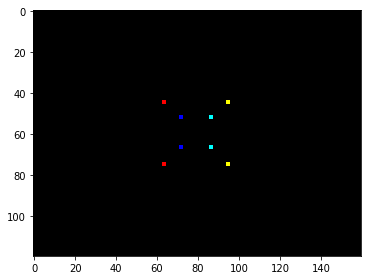

In [375]:
canvas = np.zeros((120, 160, 3), dtype=np.float32)
canvas = render(transformed, canvas, cube_colors)

plt.imshow(canvas);
plt.axis('image')
plt.tight_layout()

The view will change if we move the camera to the right:

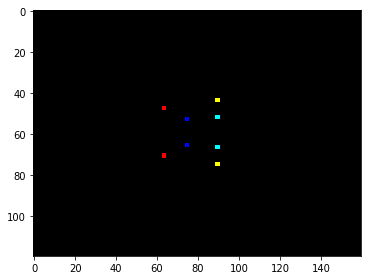

In [376]:
v = look_at_lh(eye=Vec3(.5, 0, -1.5), target=Vec3(0, 0, 0), up=Vec3(0, 1, 0))
canvas = np.zeros_like(canvas)
transformed = transform(cube_vertices, v, p)
canvas = render(transformed, canvas, cube_colors)
plt.imshow(canvas)
plt.axis('image')
plt.tight_layout();

Similarily, we can move the camera up:

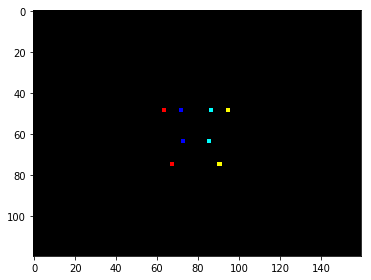

In [380]:
v = look_at_lh(eye=Vec3(0, .5, -1.5), target=Vec3(0, 0, 0), up=Vec3(0, 1, 0))
canvas = np.zeros_like(canvas)
transformed = transform(cube_vertices, v, p)
canvas = render(transformed, canvas, cube_colors)
plt.imshow(canvas)
plt.axis('image')
plt.tight_layout();

... or view the scene from the back:

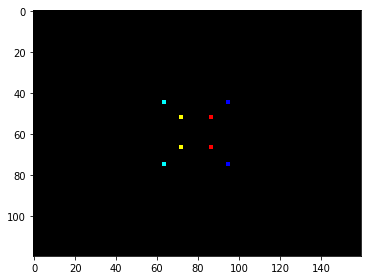

In [382]:
v = look_at_lh(eye=Vec3(0, 0, 1.5), target=Vec3(0, 0, 0), up=Vec3(0, 1, 0))
canvas = np.zeros_like(canvas)
transformed = transform(cube_vertices, v, p)
canvas = render(transformed, canvas, cube_colors)
plt.imshow(canvas)
plt.axis('image')
plt.tight_layout();